# TCR repertoire of COVID-19 patients

In this tutorial, we re-analize single-cell TCR/RNA-seq data from Liao et al. (:cite:`Liao2020`) [available from GEO as GSE145926](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE145926).

## Setup and data parsing

### Define essential metadata

In [1]:
import os
N_THREADS = str(8)
os.environ["MKL_NUM_THREADS"] = N_THREADS
os.environ["MKL_NUM_cpus"] = N_THREADS
os.environ["OMP_NUM_THREADS"] = N_THREADS
os.environ["OMP_NUM_cpus"] = N_THREADS
os.environ["OPENBLAS_NUM_THREADS"] = N_THREADS
os.environ["OPENBLAS_NUM_cpus"] = N_THREADS          

In [45]:
import scirpy as ir
import scanpy as sc
import pandas as pd
import seaborn as sns
from glob import glob
from matplotlib import pyplot as plt

In [3]:
paths_transcriptomics = sorted(glob("/data/projects/2020/covid19/processed/GSE145926/*.h5"))
paths_vdj = sorted(glob("/data/projects/2020/covid19/processed/GSE145926/*.csv.gz"))

In [4]:
samples = {
    "C141": {
        "group": "mild"
    },
    "C142" : {
        "group": "mild"
    },
    "C143": {
        "group": "severe"
    },
    "C144": {
        "group": "mild"
    },
    "C145": {
        "group": "severe"
    },
    "C146": {
        "group": "severe"
    },
    "C148": {
        "group": "healthy control"
    },
    "C149": {
        "group": "healthy control"
    },
    "C152": {
        "group": "healthy control"
    },
}

### Read transcriptomics and TCR data for samples

In [18]:
adatas = []
for sample, sample_meta in samples.items():
    glob_gex = glob(f"/data/projects/2020/covid19/processed/GSE145926/*{sample}*.h5")
    glob_tcr = glob(f"/data/projects/2020/covid19/processed/GSE145926/*{sample}*.csv.gz")
    adata = sc.read_10x_h5(glob_gex[0])
    adata_tcr = ir.read_10x_vdj(glob_tcr[0])
    ir.pp.merge_with_tcr(adata, adata_tcr)
    sample_meta['sample'] = sample
    adata.obs = adata.obs.assign(**sample_meta)
    adata.var_names_make_unique()
    adatas.append(adata)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'TRA_1_cdr3' as categorical
... storing 'TRA_2_cdr3' as categorical
... storing 'TRB_1_cdr3' as categorical
... storing 'TRB_2_cdr3' as categorical
... storing 'TRA_1_junction_ins' as categorical
... storing 'TRA_2_junction_ins' as categorical
... storing 'TRB_1_junction_ins' as categorical
... storing 'TRB_2_junction_ins' as categorical
... storing 'TRA_1_v_gene' as categorical
... storing 'TRA_2_v_gene' as categorical
... storing 'TRB_1_v_gene' as categorical
... storing 'TRB_2_v_gene' as categorical
... storing 'TRA_1_d_gene' as categorical
... storing 'TRA_2_d_gene' as categorical
... storing 'TRB_1_d_gene' as categorical
... storing 'TRB_2_d_gene' as categorical
... storing 'TRA_1_j_gene' as categorical
... storing 'TRA_2_j_gene' as categorical
... storing 'TRB_1_j_gene' as categorical
... storing 'TRB_2_j

### Merge samples and remove non-T cell data

In [19]:
adata = adatas[0].concatenate(*adatas[1:])

In [20]:
adata = adata[adata.obs["has_tcr"] == True, :].copy()

## Preprocess transcriptomics data

### Filter, normalize and explore

In [21]:
sc.pp.filter_genes(adata, min_cells=10)
sc.pp.filter_cells(adata, min_genes=200)

In [22]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1000)
sc.pp.log1p(adata)

In [24]:
sc.pp.highly_variable_genes(adata, flavor="cell_ranger", n_top_genes=3000, batch_key="batch")

... storing 'multi_chain' as categorical
... storing 'TRA_1_cdr3' as categorical
... storing 'TRA_2_cdr3' as categorical
... storing 'TRB_1_cdr3' as categorical
... storing 'TRB_2_cdr3' as categorical
... storing 'TRB_2_expr' as categorical
... storing 'TRA_1_v_gene' as categorical
... storing 'TRA_2_v_gene' as categorical
... storing 'TRB_1_v_gene' as categorical
... storing 'TRB_2_v_gene' as categorical
... storing 'TRA_1_j_gene' as categorical
... storing 'TRA_2_j_gene' as categorical
... storing 'TRB_1_j_gene' as categorical
... storing 'TRB_2_j_gene' as categorical
... storing 'TRB_2_c_gene' as categorical
... storing 'TRA_1_cdr3_nt' as categorical
... storing 'TRA_2_cdr3_nt' as categorical
... storing 'TRB_1_cdr3_nt' as categorical
... storing 'TRB_2_cdr3_nt' as categorical
... storing 'has_tcr' as categorical
... storing 'group' as categorical
... storing 'sample' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


### Cluster cells based on gene expression

In [25]:
sc.pp.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata)
sc.tl.umap(adata)

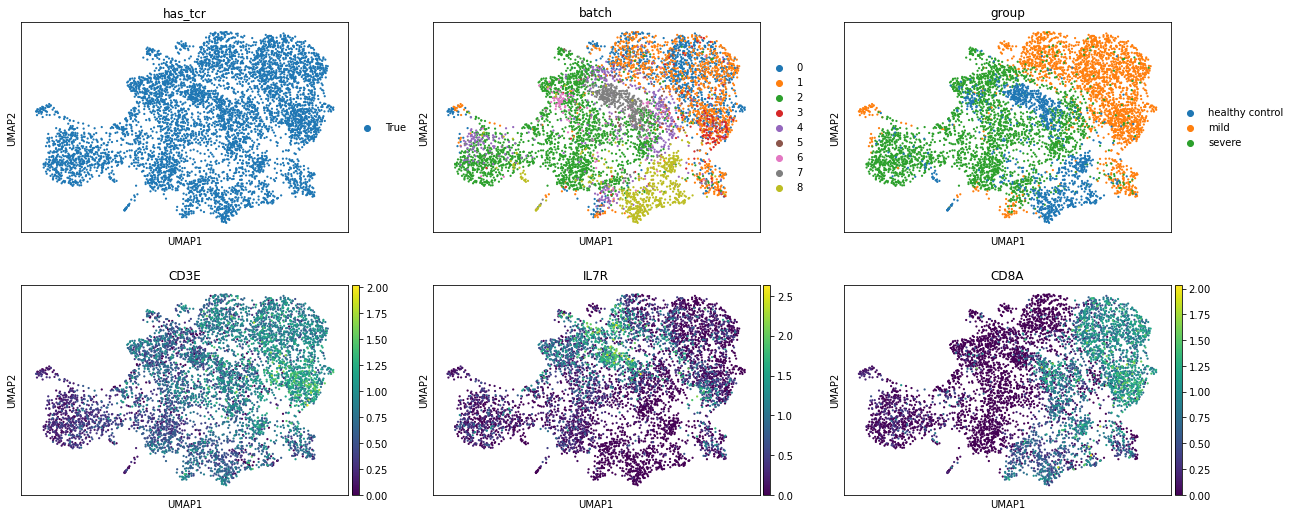

In [33]:
#sc.pl.umap(adata, color=["has_tcr", "batch", "group", "CD3E", "IL7R", "CCR7", "CD8A", "GNLY", "NKG7", "KLRB1", "CD14", "LYZ"], ncols=3) #including NK cell and monocyte markers
sc.pl.umap(adata, color=["has_tcr", "batch", "group", "CD3E", "IL7R", "CD8A"], ncols=3)

### Correct for batch effects

In [28]:
adata2 = adata.copy()

In [29]:
sc.pp.combat(adata2)

/home/szabo/.conda/envs/tcrcovid/lib/python3.7/site-packages/scanpy/preprocessing/_combat.py:340: RuntimeWarning: divide by zero encountered in true_divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()


In [30]:
sc.pp.pca(adata2, svd_solver="arpack")
sc.pp.neighbors(adata2)
sc.tl.umap(adata2)

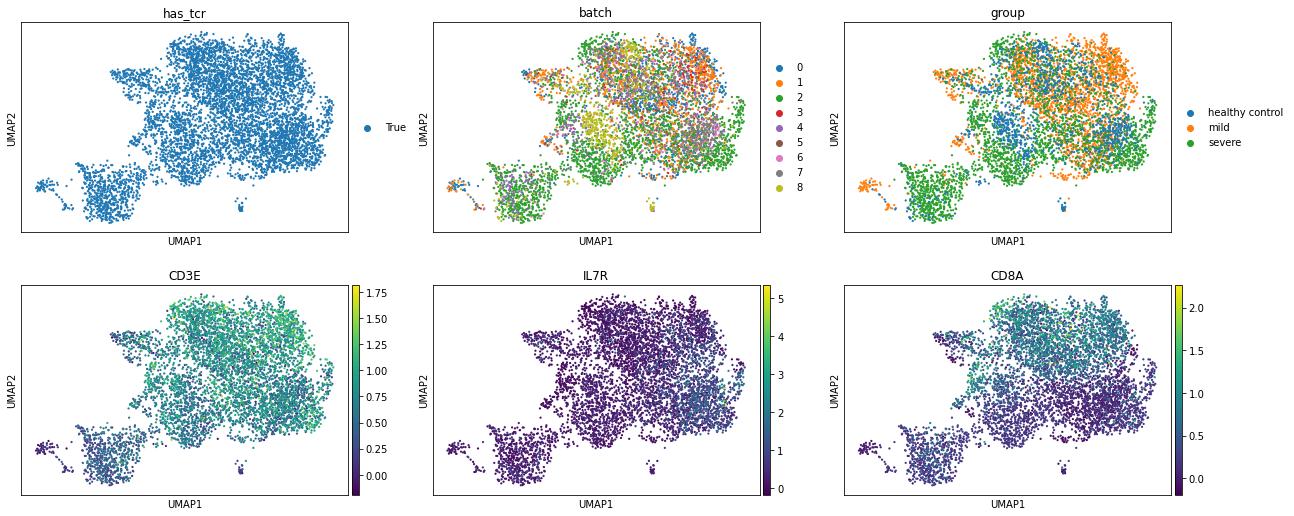

In [36]:
sc.pl.umap(adata2, color=["has_tcr", "batch", "group", "CD3E", "IL7R", "CD8A"], ncols=3)

### Carry on with the uncorrected dataset and save the current state before TCR processing

In [37]:
adata_bk = adata.copy()

## Basic information on TCR repertoire and clonotypes

### Check for unconventional receptor configurations featuring more than a single alpha- and a single beta-TCR chain sequence in a given cell

Scirpy's `chain_pairing` tool labels cells based on how many TCR alpha and beta chains could be identified in a single cell.

In [38]:
ir.tl.chain_pairing(adata)

After running the discovery tool, the number of cells in each category can be shown on a `group_abundance` plot.

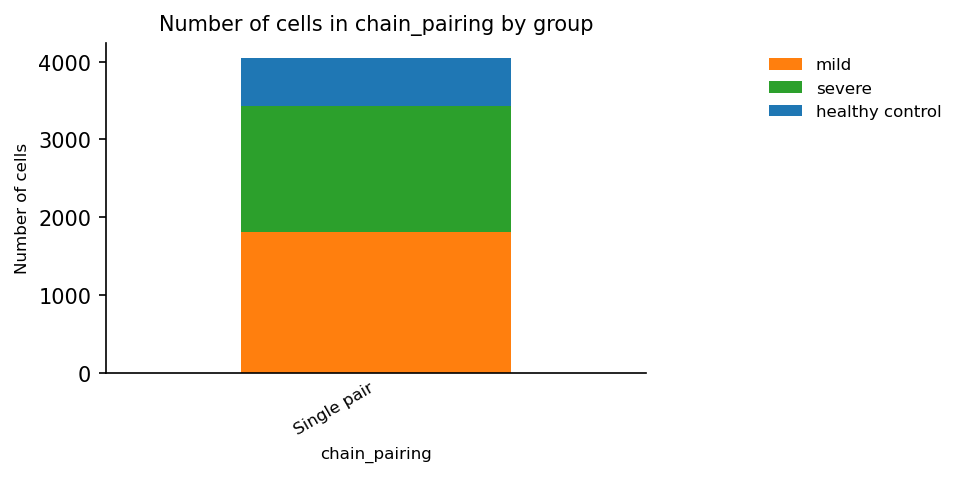

In [74]:
ir.pl.group_abundance(adata, groupby="chain_pairing", target_col="group", fig_kws={"dpi": 150})

Healthy controls feature substiantially lower absolute numbers of T-cells than the other two group. This imbalance can be corrected by normalizing to the toatl number of T-cells in each group.

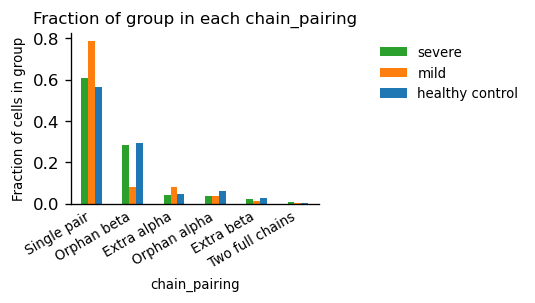

In [66]:
ir.pl.group_abundance(adata, groupby="chain_pairing", target_col="group", normalize="group", stacked=False, fig_kws={"dpi": 150})

Integration with Scanpy offers straightforward means to show the same information on a UMAP too.

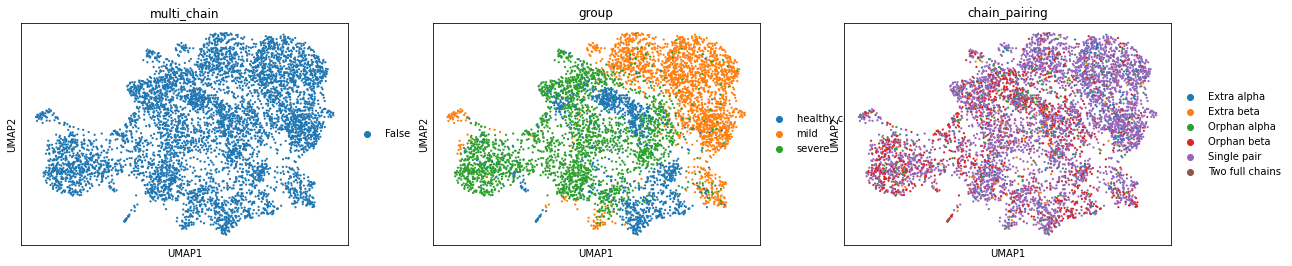

In [67]:
sc.pl.umap(adata, color=["multi_chain", "group", "chain_pairing"])

Since the majory of T-cells have a single pair of TCR alpha and beta chains; to be on the safe side, let us focus only on these T-cells.

In [68]:
adata = adata[adata.obs["chain_pairing"] == 'Single pair', :].copy()

### Clonotype sizes and definitions

In the narrowest sense, cells in a clonotype share TCRs identical at the nucleotide level. Setting cutoff to 0 and sequence to "nt" at the preprocessing step enforces this narrowest definition.

In [69]:
ir.pp.tcr_neighbors(adata, cutoff=0, receptor_arms="all", dual_tcr="primary_only", sequence="nt", key_added="tcr_neighbors_nt")
ir.tl.define_clonotypes(adata, partitions="connected", neighbors_key="tcr_neighbors_nt", key_added="clonotype_nt")

The proportion of cells with a uniqe CDR3 TCR sequence versus those having clonal peers, termed "clonal expansion plot" can give a quick overview on the clonal repertoire in severity groups. 

In [120]:
ir.tl.clonal_expansion(adata, target_col="clonotype_nt", clip_at=4)

... storing 'clonal_expansion' as categorical


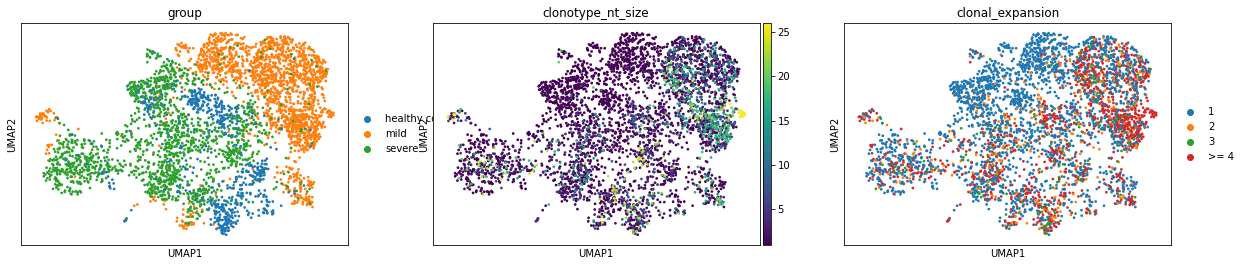

In [121]:
sc.pl.umap(adata, color=["group", "clonotype_nt_size", "clonal_expansion"])

The plotting tool `clonal_expansion` by default shows a simple overview of fractions in groups.

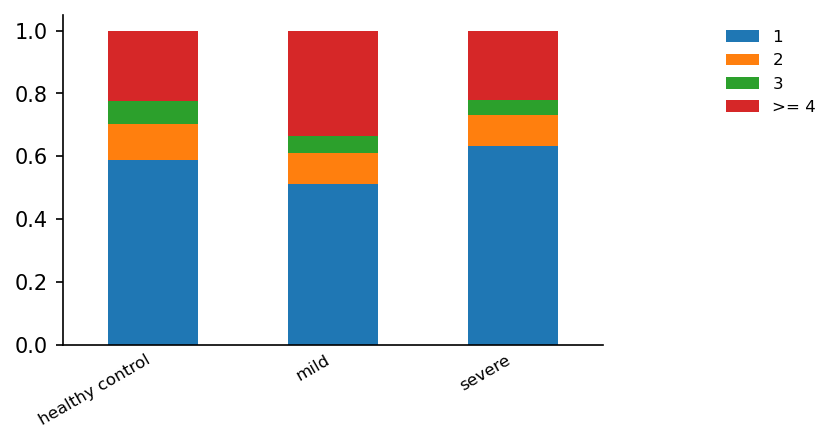

In [124]:
ir.pl.clonal_expansion(adata, "group", target_col="clonotype_nt", clip_at=4, fig_kws={"dpi": 150})

Another opportunity for visualization would be to show clonal expansions for patients by diagnosis group.

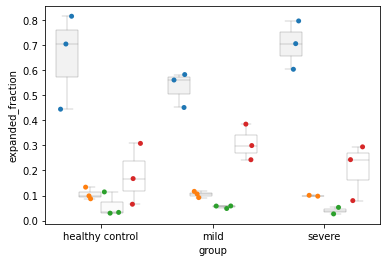

In [152]:
df = adata.obs.loc[:,["batch", "group"]]
df["expansion"] = ir.tl.clonal_expansion(adata, target_col="clonotype_nt", clip_at=4, inplace=False)
df = df.groupby(["batch", "group", "expansion"]).size().reset_index()
df = df.loc[df[0] != 0,:]
batchsizes = df.groupby(["batch"]).sum().to_dict()[0]
df["expanded_fraction"] = df[0]/df["batch"].map(batchsizes).astype('int32')
ax = sns.boxplot(x="group", y="expanded_fraction", hue="expansion", dodge=True, data=df, color="white", linewidth=0.4)
sns.stripplot(x="group", y="expanded_fraction", hue="expansion", dodge=True, data=df, ax=ax, size=5, jitter=0.3,)
ax.legend().remove()

For the expanded clonotypes, one can also discover the abundance of the top clonotypes.

[Text(0, 0, 'CAAGRFNKFYF:CAAGRFNKFYF'),
 Text(0, 0, 'CAMREDDSNYQLIW:CAMREDDSNYQLIW'),
 Text(0, 0, 'CAAGRFNKFYF:CAAGRFNKFYF'),
 Text(0, 0, 'CAAGRFNKFYF:CAAGRFNKFYF'),
 Text(0, 0, 'CAASTSGGSYIPTF:CAASTSGGSYIPTF'),
 Text(0, 0, 'CAMREDDSNYQLIW:CAMREDDSNYQLIW'),
 Text(0, 0, 'CAAGRFNKFYF:CAAGRFNKFYF'),
 Text(0, 0, 'CAAGRFNKFYF:CAAGRFNKFYF'),
 Text(0, 0, 'CAAGRFNKFYF:CAAGRFNKFYF'),
 Text(0, 0, 'CAASTSGGSYIPTF:CAASTSGGSYIPTF'),
 Text(0, 0, 'CAAGRFNKFYF:CAAGRFNKFYF'),
 Text(0, 0, 'CAMREDDSNYQLIW:CAMREDDSNYQLIW'),
 Text(0, 0, 'CAAGRFNKFYF:CAAGRFNKFYF'),
 Text(0, 0, 'CAASTSGGSYIPTF:CAASTSGGSYIPTF'),
 Text(0, 0, 'CAASTSGGSYIPTF:CAASTSGGSYIPTF')]

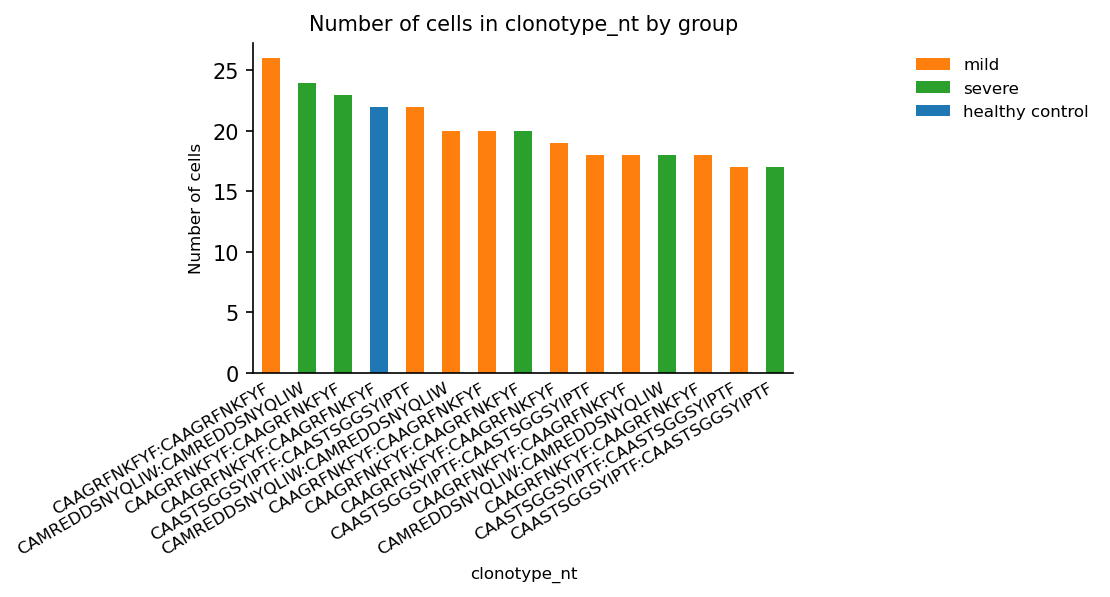

In [164]:
ax = ir.pl.group_abundance(adata, groupby="clonotype_nt", target_col="group", max_cols=15, fig_kws={"dpi": 150})
labeltable = adata.obs.loc[adata.obs["clonotype_nt"].isin([x.get_text() for x in ax.get_xticklabels()]), ["TRA_1_cdr3", "TRB_1_cdr3"]]
labeltable["names"] = labeltable["TRA_1_cdr3"].astype(str)+":"+labeltable["TRA_1_cdr3"].astype(str)
ax.set_xticklabels(labeltable["names"])

In the end, TCR sequences with distinct nucleotide, but same amino acid sequences will be functionally identical.

In [166]:
ir.pp.tcr_neighbors(adata, cutoff=0, receptor_arms="all", dual_tcr="primary_only", key_added="tcr_neighbors_aa")
ir.tl.define_clonotypes(adata, neighbors_key="tcr_neighbors_aa", key_added="clonotype_aa")

    Finished initalizing TcrNeighbors object. 
Finished computing TRA pairwise distances.
Finished computing TRB pairwise distances.
    Finished constructing coord-dictionary
Finished constructing cell x cell distance matrix. 
    Finished converting distances to connectivities. 


[Text(0, 0, 'CAAGRFNKFYF:CAAGRFNKFYF'),
 Text(0, 0, 'CAMREDDSNYQLIW:CAMREDDSNYQLIW'),
 Text(0, 0, 'CAAGRFNKFYF:CAAGRFNKFYF'),
 Text(0, 0, 'CAAGRFNKFYF:CAAGRFNKFYF'),
 Text(0, 0, 'CAASTSGGSYIPTF:CAASTSGGSYIPTF'),
 Text(0, 0, 'CAMREDDSNYQLIW:CAMREDDSNYQLIW'),
 Text(0, 0, 'CAAGRFNKFYF:CAAGRFNKFYF'),
 Text(0, 0, 'CAAGRFNKFYF:CAAGRFNKFYF'),
 Text(0, 0, 'CAAGRFNKFYF:CAAGRFNKFYF'),
 Text(0, 0, 'CAASTSGGSYIPTF:CAASTSGGSYIPTF'),
 Text(0, 0, 'CAAGRFNKFYF:CAAGRFNKFYF'),
 Text(0, 0, 'CAMREDDSNYQLIW:CAMREDDSNYQLIW'),
 Text(0, 0, 'CAAGRFNKFYF:CAAGRFNKFYF'),
 Text(0, 0, 'CAASTSGGSYIPTF:CAASTSGGSYIPTF'),
 Text(0, 0, 'CAASTSGGSYIPTF:CAASTSGGSYIPTF')]

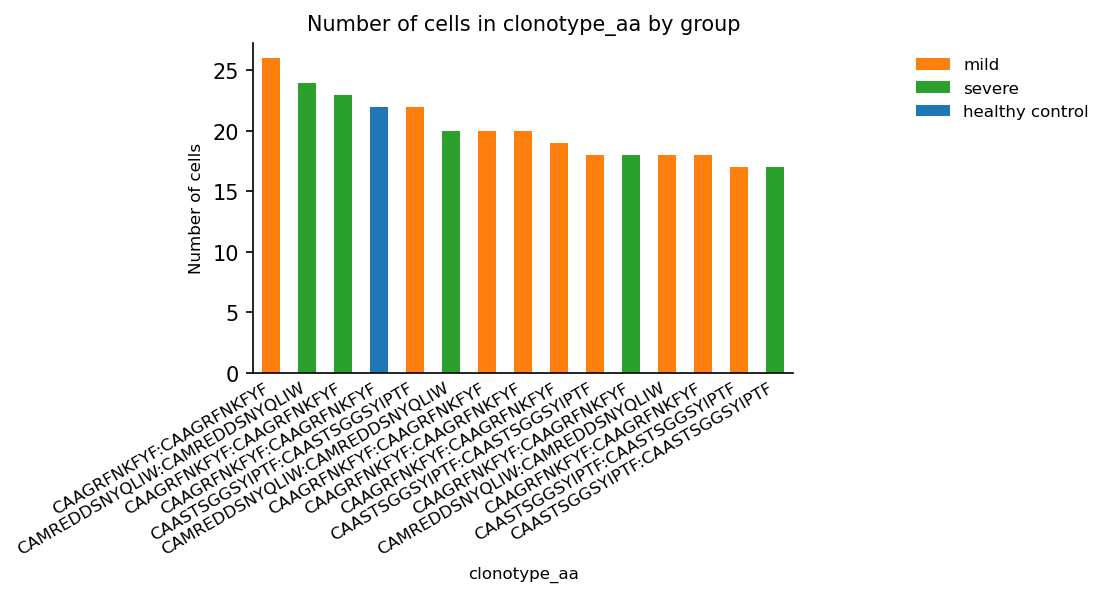

In [168]:
ax = ir.pl.group_abundance(adata, groupby="clonotype_aa", target_col="group", max_cols=15, fig_kws={"dpi": 150})
labeltable = adata.obs.loc[adata.obs["clonotype_aa"].isin([x.get_text() for x in ax.get_xticklabels()]), ["TRA_1_cdr3", "TRB_1_cdr3"]]
labeltable["names"] = labeltable["TRA_1_cdr3"].astype(str)+":"+labeltable["TRA_1_cdr3"].astype(str)
ax.set_xticklabels(labeltable["names"])

Convergence of nucleotide sequences to the same amino acid sequence hint at biological relevance of a certain CDR3 amino acid sequence.

In [78]:
def find_convergence(adata, key_coarse, key_fine):
    return adata.obs.loc[:, [key_coarse, key_fine]].groupby(key_coarse).apply(lambda X: X[key_fine].unique().size)
convergent = find_convergence(adata, "clonotype_aa", "clonotype_nt")
convergent.loc[convergent > 1]

clonotype_aa
1293    2
1632    2
2074    2
533     2
706     2
894     2
977     2
dtype: int64

In [88]:
adata.obs.loc[adata.obs["clonotype_aa"] == "2074"]

,multi_chain,TRA_1_cdr3,TRA_2_cdr3,TRB_1_cdr3,TRB_2_cdr3,TRA_1_junction_ins,TRA_2_junction_ins,TRB_1_junction_ins,TRB_2_junction_ins,TRA_1_expr,...,group,sample,batch,n_genes,n_counts,chain_pairing,clonotype_nt,clonotype_nt_size,clonotype_aa,clonotype_aa_size
AACGTTGTCAGCGACC-1-4,False,CAVRDGNTDKLIF,None,CASSYQGRGNEQFF,None,None,None,None,None,2.0,...,severe,C145,4,1274,2617.0,Single pair,2080,2,2074,4
CCGTACTTCTCTGAGA-1-4,False,CAVRDGNTDKLIF,None,CASSYQGRGNEQFF,None,None,None,None,None,1.0,...,severe,C145,4,1061,1928.0,Single pair,2147,2,2074,4
GCATGATGTCTAGAGG-1-4,False,CAVRDGNTDKLIF,None,CASSYQGRGNEQFF,None,None,None,None,None,1.0,...,severe,C145,4,2267,5351.0,Single pair,2080,2,2074,4
TTTACTGAGCGTGAAC-1-4,False,CAVRDGNTDKLIF,None,CASSYQGRGNEQFF,None,None,None,None,None,1.0,...,severe,C145,4,1698,3922.0,Single pair,2147,2,2074,4


Another measure often applied to the adaptive immune receptor repertoire is diversity. 

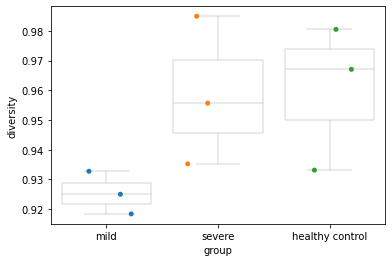

In [200]:
df = ir.tl.alpha_diversity(adata, target_col="clonotype_nt", groupby="batch", inplace=False).reset_index()
df.columns = ["batch", "diversity"]
sample_groups = adata.obs.loc[:,["batch", "group"]].groupby(["batch", "group"]).size().reset_index()
sample_groups = sample_groups.loc[sample_groups[0] != 0,:].set_index("batch").loc[:,"group"].to_dict()
df["group"] = df["batch"].map(sample_groups)
ax = sns.boxplot(x="group", y="diversity", dodge=True, data=df, color="white", linewidth=0.4)
sns.stripplot(x="group", y="diversity", dodge=True, data=df, ax=ax, size=5, jitter=0.3,)

## V(D)J gene usage and spectratypes

### Most abundant V gene segments by groups

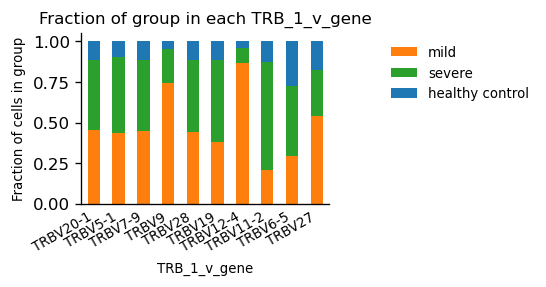

In [216]:
ax = ir.pl.group_abundance(adata, groupby="TRB_1_v_gene", target_col="group", normalize=True, max_cols=10)
top_v_genes = [x.get_text() for x in ax.get_xticklabels()]

Cells featuring these segments can be shown on UMAP

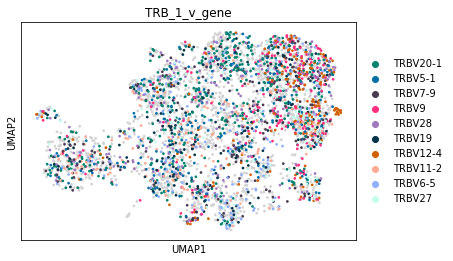

In [219]:
sc.pl.umap(adata, color="TRB_1_v_gene", groups=top_v_genes)

### V(D)J combinations featuring TRBV12-4 in mild infection

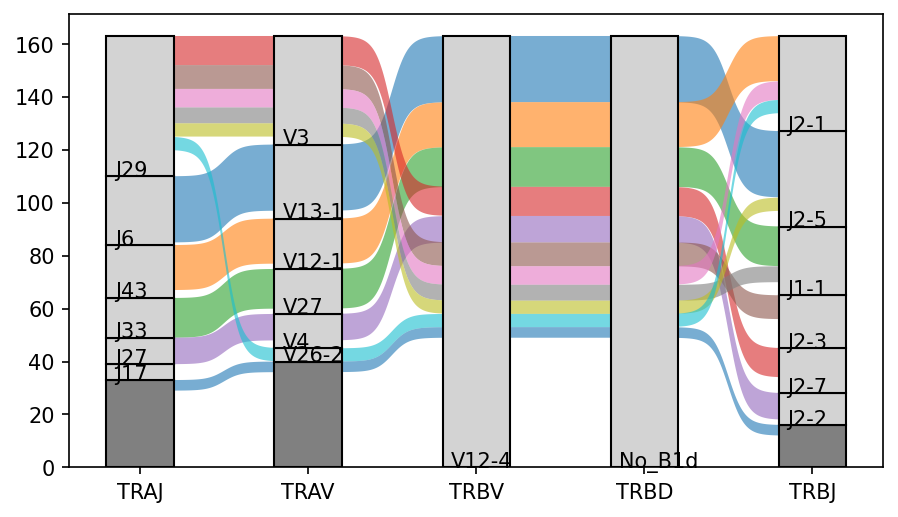

In [225]:
ir.pl.vdj_usage(adata[(adata.obs["group"] == "mild") & (adata.obs["TRB_1_v_gene"] == "TRBV12-4")], fig_kws={"dpi": 150})

### Length distribution of CDR3 regions by V genes: a special type of spectratype

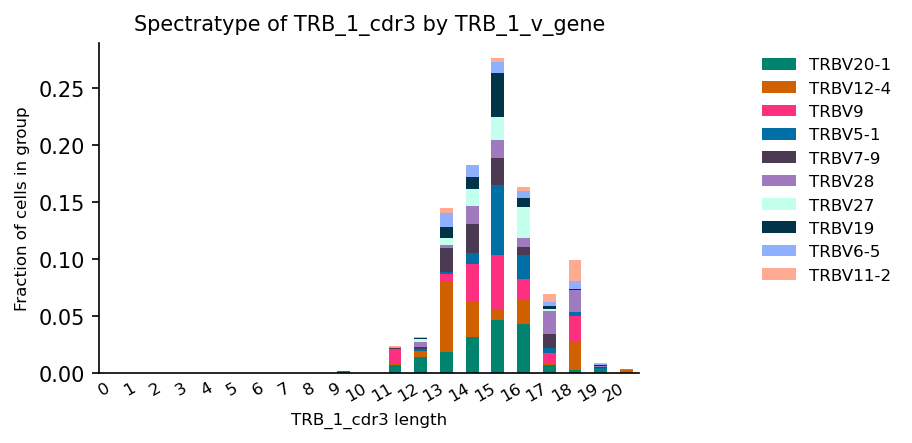

In [227]:
ir.pl.spectratype(
    adata[(adata.obs["TRB_1_v_gene"].isin(top_v_genes)) & (adata.obs["group"] == "mild"),:],
    cdr3_col="TRB_1_cdr3",
    color="TRB_1_v_gene",
    normalize="group",
    fig_kws={"dpi": 150},
)

### Conventional spectratypes

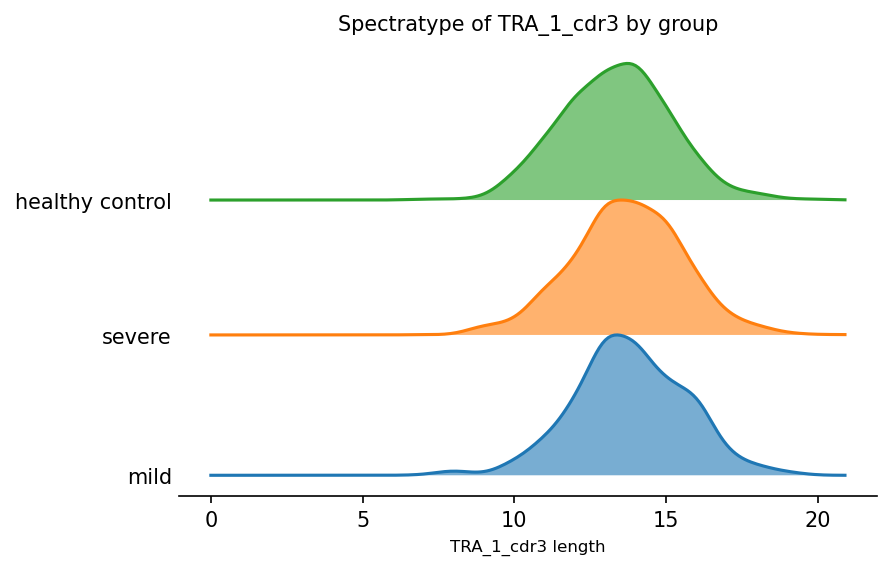

In [212]:
ir.pl.spectratype(
    adata,
    color="group",
    viztype="curve",
    curve_layout = "shifted",
    fig_kws={"dpi": 150},
    kde_kws={"kde_norm": True},
)

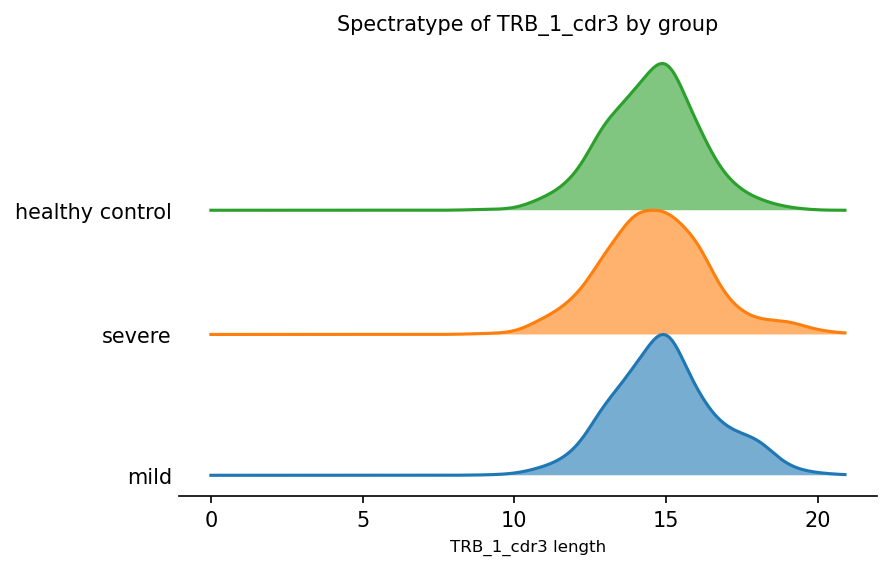

In [211]:
ir.pl.spectratype(
    adata,
    cdr3_col="TRB_1_cdr3",
    color="group",
    viztype="curve",
    curve_layout = "shifted",
    fig_kws={"dpi": 150},
    kde_kws={"kde_norm": True},
)

### Clontype clusters

An additional layer of connectivity between TCR sequences is conferred to by amino acid sequence similarity. Scirpy can exploit this information by redefining clonotypes.

In [91]:
sc.settings.verbosity = 4

In [92]:
ir.pp.tcr_neighbors(adata, cutoff=15, receptor_arms="all", dual_tcr="all", key_added="tcr_neighbors_blosum")
ir.tl.define_clonotypes(adata, partitions="connected", neighbors_key="tcr_neighbors_blosum", key_added="clonotype_blosum")

    Finished initalizing TcrNeighbors object. 


100%|██████████| 2628/2628 [00:06<00:00, 398.68it/s]


Finished computing TRA pairwise distances.


100%|██████████| 2675/2675 [00:06<00:00, 391.07it/s]


Finished computing TRB pairwise distances.
    Finished constructing coord-dictionary
Finished constructing cell x cell distance matrix. 
    Finished converting distances to connectivities. 


Amino acid similarity based clonotype clusters can then be visualized as networks.

In [93]:
ir.tl.clonotype_network(adata, min_size=3, layout="components", neighbors_key="tcr_neighbors_blosum",
                        key_clonotype_size="clonotype_blosum_size")

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5d21527910>,
      dtype=object)

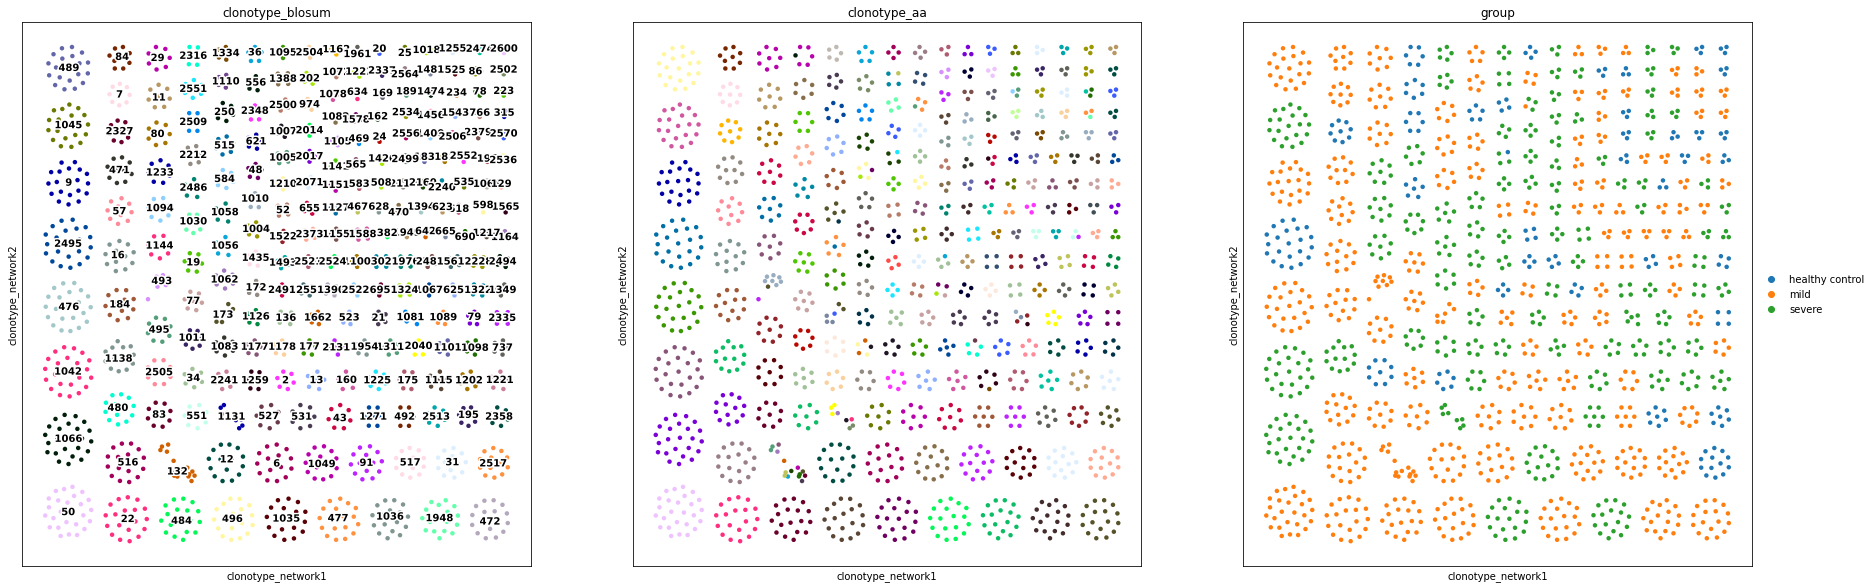

In [95]:
ir.pl.clonotype_network(adata, color=["clonotype_blosum", "clonotype_aa", "group"],
                        legend_loc=["on data", "none", "right margin"], legend_fontoutline=3, size=80, edges=False)

### Repertoire overlaps

Both clonotype abundance and network visualizations hint at the lack of overlap between TCR repertoire of the three diagnosis groups. This can be visualized directly with Scirpy.

In [173]:
ir.tl.repertoire_overlap(adata, "group", target_col="clonotype_aa")

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


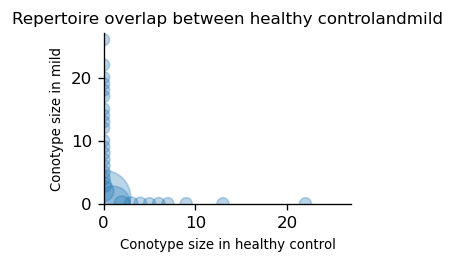

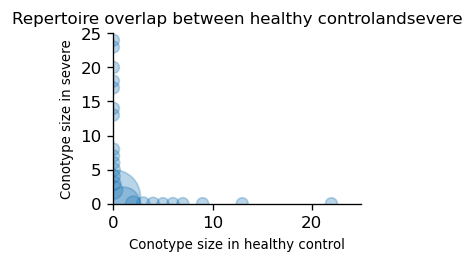

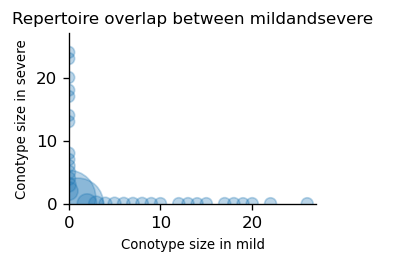

In [177]:
ir.pl.repertoire_overlap(adata, "group", pair_to_plot=["healthy control", "mild"])
ir.pl.repertoire_overlap(adata, "group", pair_to_plot=["healthy control", "severe"])
ir.pl.repertoire_overlap(adata, "group", pair_to_plot=["mild", "severe"])

Flexibility in clonotype definition yields shared clusters.

In [178]:
ir.tl.repertoire_overlap(adata, "group", target_col="clonotype_blosum")

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


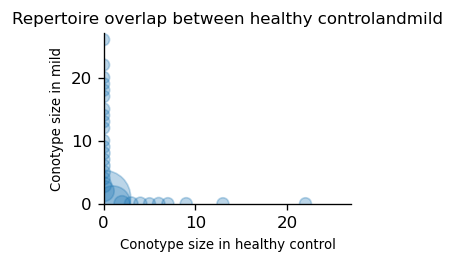

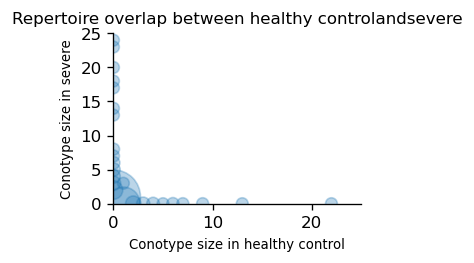

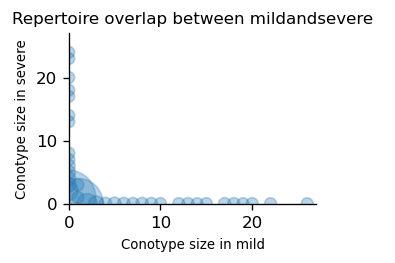

In [179]:
ir.pl.repertoire_overlap(adata, "group", pair_to_plot=["healthy control", "mild"])
ir.pl.repertoire_overlap(adata, "group", pair_to_plot=["healthy control", "severe"])
ir.pl.repertoire_overlap(adata, "group", pair_to_plot=["mild", "severe"])

Jaccard's distance of samples offers a global overview of relationships.

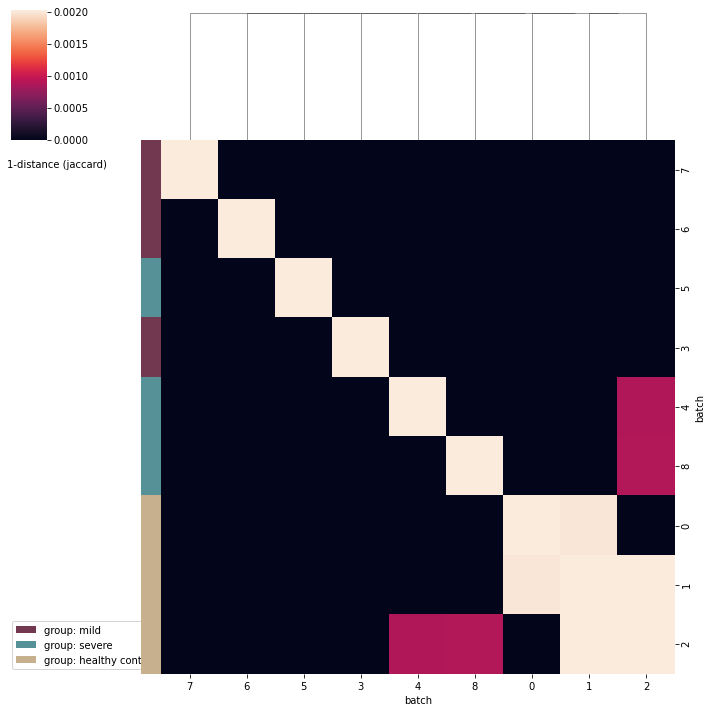

In [181]:
ir.tl.repertoire_overlap(adata, "batch", target_col="clonotype_blosum")
ir.pl.repertoire_overlap(adata, "batch", heatmap_cats=["group"])

## Integrate clonotype information with gene expression

### Marker genes for clonotype clusters

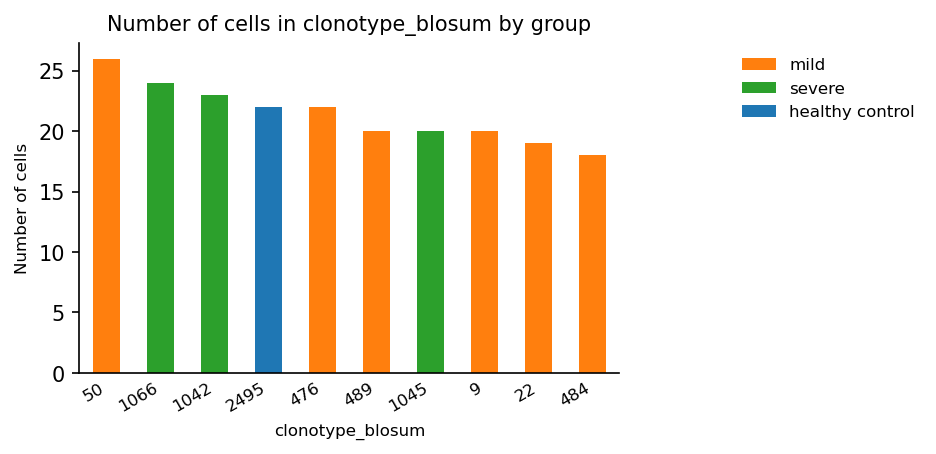

In [251]:
ax = ir.pl.group_abundance(adata, groupby="clonotype_blosum", target_col="group", max_cols=10, fig_kws={"dpi": 150})
top_clonotype_clusters = [x.get_text() for x in ax.get_xticklabels()]
top_clonotype_clusters = top_clonotype_clusters[:5]

In [252]:
sc.tl.rank_genes_groups(adata, "clonotype_blosum", groups=top_clonotype_clusters, method="wilcoxon")

ranking genes
    consider 'clonotype_blosum' groups:
    with sizes: [26 24 23 22 22]
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:05)


categories: healthy control, mild, severe
var_group_labels: 50, 1066, 1042, etc.


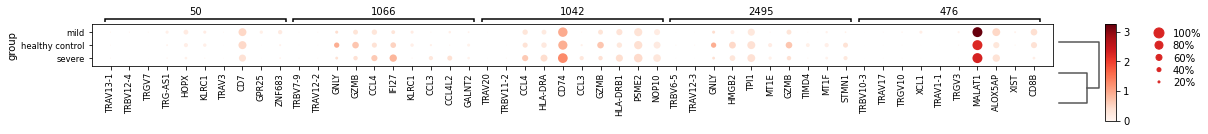

In [255]:
sc.pl.rank_genes_groups_dotplot(adata, groups=top_clonotype_clusters, groupby="group", n_genes=10)

### Marker genes for selected clonotype clusters

Cluster No.489 is one of the largest clonotype groups in mild infection, while the largest group in severe infection is No.1045; find marker genes that differantiate these two clusters.

In [243]:
sc.tl.rank_genes_groups(adata, "clonotype_blosum", groups=["489"], reference="1045", method="wilcoxon")

ranking genes
    consider 'clonotype_blosum' groups:
    with sizes: [20 20]
--> Few observations in a group for normal approximation (<=25). Lower test accuracy.
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


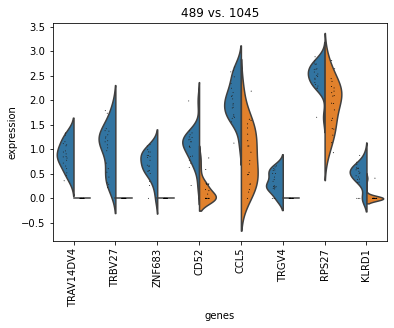

In [244]:
sc.pl.rank_genes_groups_violin(adata, groups="489", n_genes=8)

Higher expression of CD52, a marker for mature T-cells, CCL5 (RANTES), known to be important in efficient antiviral response and KLRD1, an NK cell antigen suggests that the immune activation stae of cells in these two clusters are indeed different.

In [257]:
adata.var_names

Index(['AL627309.1', 'AL669831.5', 'LINC00115', 'FAM41C', 'NOC2L', 'KLHL17',
       'PLEKHN1', 'AL645608.8', 'HES4', 'ISG15',
       ...
       'MT-ND6', 'MT-CYB', 'AC145212.1', 'MAFIP', 'AC011043.1', 'AL592183.1',
       'AL354822.1', 'AC004556.1', 'AC240274.1', 'nCoV'],
      dtype='object', length=15469)

### Expression of chemokines and cytokines in top clonotype clusters

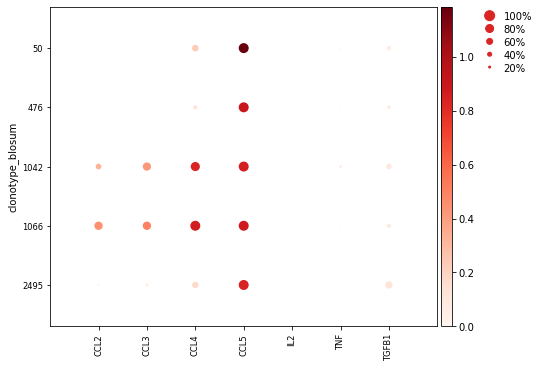

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[7.05, 0, 0.2, 0.5, 0.25])

In [261]:
sc.pl.dotplot(adata[adata.obs["clonotype_blosum"].isin(top_clonotype_clusters),:], ['CCL2', 'CCL3', 'CCL4', 'CCL5', 'IL2', 'TNF', 'TGFB1'], groupby="clonotype_blosum", figsize=(8, 6))